In [1]:
import os

import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
f = gzip.GzipFile(r"../../Data/rBergomiTrainSet.txt.gz", "r")
dat=np.load(f)
xx=dat[:,:4]
yy=dat[:,4:]
strikes=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])
maturities=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


x_train, x_test, y_train, y_test = train_test_split(
    xx, yy, test_size=0.15, random_state=42)

In [3]:
def append_and_expand(a,x,y):
    # use choose and where !
    n = len(x)*len(y)
    a_index = np.arange(len(a))%n
    
    
    x_index = a_index//len(y)
    y_index = a_index%len(y)
    
    x_added = np.choose(x_index,x.reshape(-1,1)).reshape(-1,1)
    y_added = np.choose(y_index,y.reshape(-1,1)).reshape(-1,1)
    
    return np.hstack([a,x_added,y_added])

y_train,y_test = y_train.reshape(-1,8,11),y_test.reshape(-1,8,11)
x_train,x_test = np.repeat(x_train, 8*11,axis=0),np.repeat(x_test, 8*11,axis=0)

In [4]:
x_train,x_test=append_and_expand(x_train,maturities,strikes),append_and_expand(x_test,maturities,strikes)
y_train,y_test = y_train.reshape(-1).reshape(-1,1), y_test.reshape(-1).reshape(-1,1)

In [5]:
import torch
import torch.nn as nn

scale_y=  StandardScaler()

def ytransform(y_train,y_test):
    return [scale_y.fit_transform(y_train),scale_y.transform(y_test)]

def yinversetransform(y):
    return scale_y.inverse_transform(y)

# Upper and lower bounds used in the training set
ub=np.array([0.16,4,-0.1,0.5,2.0,1.5])
lb=np.array([0.01,0.3,-0.95,0.025,0.1,0.5])

def myscale(x):
    return (x - (ub+lb)*0.5)*2/(ub-lb)
def myinverse(x):
    return x*(ub-lb)*0.5+(ub+lb)*0.5

x_train_transform = myscale(x_train)
x_test_transform = myscale(x_test)
[y_train_transform,y_test_transform] = ytransform(y_train,y_test)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"device is {device}")

train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_train_transform).to(device=device),
                                               torch.from_numpy(y_train_transform).to(device=device))
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_test_transform).to(device=device),
                                              torch.from_numpy(y_test_transform).to(device=device))


train_data = (torch.from_numpy(x_train_transform).to(device=device),torch.from_numpy(y_train_transform).to(device=device))
test_data = (torch.from_numpy(x_test_transform).to(device=device),torch.from_numpy(y_test_transform).to(device=device))

data_loader = torch.utils.data.DataLoader(train_dataset,batch_size =88,shuffle=False)

device is cuda


In [6]:
import sys
sys.path.append('../../')  # Add the parent directory to the Python path

from torch_NN.nn import ResNN_pricing

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

hyperparas = {'input_dim':6,'hidden_dim':64,'hidden_nums':10,'output_dim':1,'block_layer_nums':3}

model = ResNN_pricing(hyperparas=hyperparas).to(device=device,dtype=torch.float64)

loss_MSE = nn.MSELoss()
optim_Adam = torch.optim.Adam(model.parameters(),lr= 0.0001)

-----------------------Epoch: 0----------------------------------
Batch: 0,train loss is: 1.1867440781734666
test loss is 1.585635669494096
Batch: 100,train loss is: 0.6773497952116992
test loss is 0.32458406005914753
Batch: 200,train loss is: 0.034135306484978756
test loss is 0.15046069978581594
Batch: 300,train loss is: 0.07667411687015212
test loss is 0.11057684892713483
Batch: 400,train loss is: 0.022256620923481407
test loss is 0.08499628935544178
Batch: 500,train loss is: 0.06972948235296496
test loss is 0.07448597434448725
Batch: 600,train loss is: 0.04439371790959378
test loss is 0.06766715548970133
Batch: 700,train loss is: 0.014705220567723753
test loss is 0.06047685814233061
Batch: 800,train loss is: 0.018446212647522896
test loss is 0.05024565259915624
Batch: 900,train loss is: 0.01925664573481065
test loss is 0.044208270534145326
Batch: 1000,train loss is: 0.01584588421485247
test loss is 0.03908852071657136
Batch: 1100,train loss is: 0.15745152681234323
test loss is 0.058

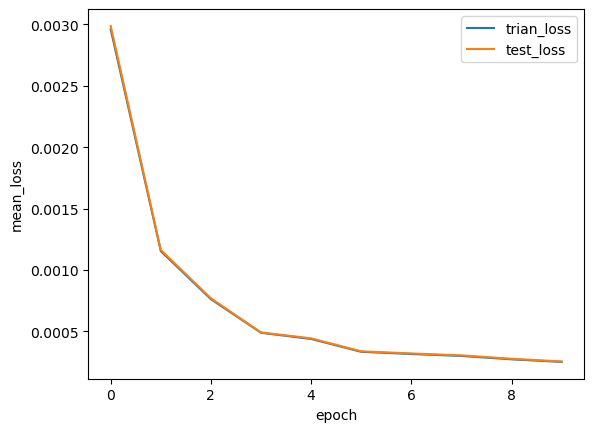

In [7]:
from torch_NN.train import train_model

train_model(loss_MSE,optim_Adam,model,data_loader,train_data,test_data,10)

-----------------------Epoch: 0----------------------------------
Batch: 0,train loss is: 0.00015938306118040346
test loss is 0.00026589435373596394
Batch: 100,train loss is: 0.00018291812182440233
test loss is 0.00019714359289503279
Batch: 200,train loss is: 0.00014783317508543868
test loss is 0.00017317530026282716
Batch: 300,train loss is: 8.729125595704304e-05
test loss is 0.00017470230136676086
Batch: 400,train loss is: 0.00012360176831352634
test loss is 0.00016690938990650823
Batch: 500,train loss is: 0.00013904636590840488
test loss is 0.00017917966054503942
Batch: 600,train loss is: 0.00013363104417950478
test loss is 0.00018607758511154942
Batch: 700,train loss is: 8.954739138974364e-05
test loss is 0.0001707791805521262
Batch: 800,train loss is: 0.00020195557220911424
test loss is 0.00016495444312846158
Batch: 900,train loss is: 7.113716709802596e-05
test loss is 0.000163829578199741
Batch: 1000,train loss is: 0.00010137130871827813
test loss is 0.0001632520594489481
Batch: 

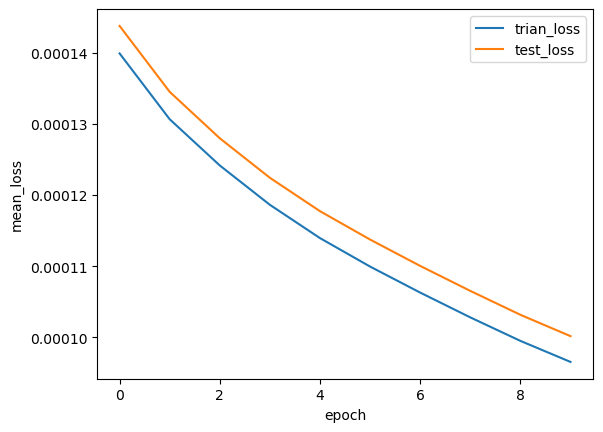

In [8]:
optim_Adam = torch.optim.Adam(model.parameters(),lr= 0.00001)
train_model(loss_MSE,optim_Adam,model,data_loader,train_data,test_data,10)

In [9]:
torch.save(model.state_dict(),'../../Data/YU/rflatBergomi_pointwise88.pth')